In [1]:
%matplotlib inline

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
import tensorflow as tf
import numpy as np 

In [3]:
def taylor_nn(prev_layer, weights, biases, com_type1, com_type2, act_type, num_of_layers, expansion_order, name ='U'):
    """Apply a NN to input from previous later

    Arguments:
        prev_layer      -- input from previous NN
        weights         -- dictionary of weights
        biases          -- dictionary of biases (uniform(-1,1) distribution, normal(0,1) distrubution, none--zeros)
        act_type        -- dictionary of activation functions (sigmoid, relu, elu, or none): user option 
        num_of_layers   -- number of weight matrices or layers: user option 
        expansion_order -- dictionary of Taylor expansion order: user option 

    Returns:
        output of network for input from previous layer
    """
    
    for i in np.arange(num_of_layers):
        
        #Compressor One###
        if com_type1['com1%s%d' % (name,i + 1)] == 'sigmoid':
            prev_layer = tf.sigmoid(prev_layer)
        elif com_type1['com1%s%d' % (name,i + 1)] == 'relu':
            prev_layer = tf.nn.relu(prev_layer)
        elif com_type1['com1%s%d' % (name,i + 1)] == 'none':
            prev_layer = prev_layer
        ###################################################################################################################################
        
        #Compressor Two###
        if com_type2['com2%s%d' % (name,i + 1)] == 'sigmoid':
            prev_layer = tf.sigmoid(prev_layer)
        elif com_type2['com2%s%d' % (name,i + 1)] == 'none':
            prev_layer = prev_layer
        ###################################################################################################################################

        #save raw input###
        input_raw = prev_layer
        raw_input_shape = input_raw.shape
        ###################################################################################################################################
        
        #The expaned input via Taylor expansion is denoted by input_epd###
        input_epd = input_raw
        ###################################################################################################################################
        
        #Anxiliary index###
        Id = np.arange(raw_input_shape[0])
        ###################################################################################################################################
        
        #Nolinear mapping through Taylor expansion###
        for _ in range(expansion_order['E%s%d' % (name, i +  1)]):
            for j in range(raw_input_shape[0]):
                for q in range(raw_input_shape[1]):
                    x_temp = np.multiply(input_raw[j,q], input_epd[Id[j]:(Id[raw_input_shape[0]-1]+1),q])
                    if q == 0:
                        tem_temp = x_temp
                    else:
                        tem_temp = np.concatenate((tem_temp,x_temp),1)
                Id[j] = input_epd.shape[0] 
                input_epd = np.concatenate((input_epd,tem_temp),0)
        ###################################################################################################################################
                
        #print(weights['W%s%d' % (name,i + 1)].shape)   
        #print(input_epd.shape) 
        #print(biases['b%s%d' % (name,i + 1)].shape) 
            
        prev_layer = np.matmul(weights['W%s%d' % (name,i + 1)],input_epd) + biases['b%s%d' % (name,i + 1)] 

        if act_type['act%s%d' % (name,i + 1)] == 'sigmoid':
            prev_layer = tf.sigmoid(prev_layer)
        elif act_type['act%s%d' % (name,i + 1)] == 'relu':
            prev_layer = tf.nn.relu(prev_layer)
        elif act_type ['act%s%d' % (name,i + 1)] == 'elu':
            prev_layer = tf.nn.elu(prev_layer)
        elif act_type ['act%s%d' % (name,i + 1)] == 'none':
            prev_layer = prev_layer
        ###################################################################################################################################    
        
    return prev_layer    
        

In [4]:
##Model Parameters#########################################################################################################
params = {}
input_dim = 2; 
params['uncheckable_dist_weights'] = ['tn']
params['uncheckable_output_size'] = [input_dim,2]
params['uncheckable_epd'] = np.array([3])
params['uncheckable_act'] = ['none']

params['uncheckable_com_type1'] = ['none']
params['uncheckable_com_type2'] = ['none']
params['uncheckable_dist_biases'] = ['none']
params['uncheckable_num_of_layers'] = len(np.array([0])) 

###########################################################################################################################

In [5]:
##Load Weights, bias, activation and expansion order#####################################################################################################
WC = dict()
WU = dict()
bC = dict()
bU = dict()
act_typeC = dict()
act_typeU = dict()
com_typeU1 = dict() 
com_typeU2 = dict()
expansion_orderU = dict()




for j in range(params['uncheckable_num_of_layers']):
    WU['WU%d' % (j + 1)] = np.matrix(np.loadtxt("../taylor_test_com_none/exp_1_WU%d.csv" % (j+1), delimiter=',', dtype=np.float64)) 
    bU['bU%d' % (j + 1)] = np.transpose(np.matrix(np.loadtxt("../taylor_test_com_none/exp_1_bU%d.csv" % (j+1), delimiter=',', dtype=np.float64)))    
    act_typeU['actU%d' % (j + 1)] = params['uncheckable_act'][j]
    expansion_orderU['EU%d' % (j + 1)] = params['uncheckable_epd'][j]
    
    com_typeU1['com1U%d' % (j + 1)] = params['uncheckable_com_type1'][j]
    com_typeU2['com2U%d' % (j + 1)] = params['uncheckable_com_type2'][j]
    
    
    
    
#for i in range(params['checkable_num_of_layers']):
    #if i == 0:
        #WC['WC%d' % (i + 1)] = np.transpose(np.matrix(np.loadtxt("../taylor_test/exp_1_WC%d.csv" % (i+1), delimiter=',', dtype=np.float64)))
    #else:
#    WC['WC%d' % (i + 1)] = np.matrix(np.loadtxt("../test0/exp_1_WC%d.csv" % (i+1), delimiter=',', dtype=np.float64))    
#    bC['bC%d' % (i + 1)] = np.transpose(np.matrix(np.loadtxt("../test0/exp_1_bC%d.csv" % (i+1), delimiter=',', dtype=np.float64)))
#    act_typeC['actC%d' % (i + 1)] = params['uncheckable_act'][i]
#    expansion_orderC['EC%d' % (i + 1)] = params['uncheckable_epd'][i]
############################################################################################################################

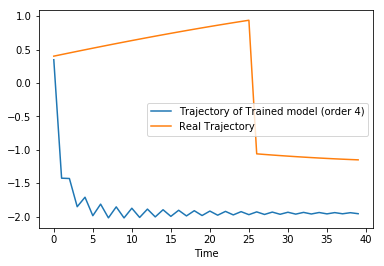

In [6]:
##Create DeepTaylor for a detailed problem################################################################################################
x = np.transpose(np.matrix([2.35181676077799,3.12966041348772]))

zz = 40
kf =  11805

Y = np.empty(zz, dtype=object)


for i in range(zz):

    
    y = taylor_nn(prev_layer=x, weights=WU, biases=bU, com_type1=com_typeU1, com_type2=com_typeU2, act_type=act_typeU, 
                  num_of_layers=params['uncheckable_num_of_layers'], expansion_order=expansion_orderU,name='U')
    

    Y[i] = y[0]
    x = y
    

Or = np.matrix(np.loadtxt("../data/Pendulum_train1_y.csv",delimiter=',', dtype=np.float64))     
   
Z = Or[kf:(zz+kf),0]  

t = np.arange(zz)
t = np.reshape(t,(zz,1))
    
    
#fig, axs = plt.subplots(1, 2)
#axs[0].plot(t, Y,'tab:orange')
#axs[0].set_title('Trajectory of Trained Model')
plt.plot(t,Y,t,Z)
plt.xlabel("Time")
plt.gca().legend(('Trajectory of Trained model (order 4)','Real Trajectory'))
plt.show()
########################################################################################################################################### 

In [7]:
##Model Parameters#########################################################################################################
params = {}
input_dim = 3; 
params['uncheckable_dist_weights'] = ['tn']
params['uncheckable_output_size'] = [input_dim,3]
params['uncheckable_epd'] = np.array([4])
params['uncheckable_act'] = ['none']
params['uncheckable_dist_biases'] = ['uniform']
params['uncheckable_num_of_layers'] = len(np.array([0])) 

params['checkable_dist_weights'] = ['tn']
params['checkable_output_size'] = [3,3]
params['checkable_epd'] = np.array([4])
params['checkable_act'] = ['none']
params['checkable_dist_biases'] = ['none']
params['checkable_num_of_layers'] = len(np.array([0])) 
###########################################################################################################################

In [8]:
##Load Weights, bias, activation and expansion order#####################################################################################################
WC = dict()
WU = dict()
bC = dict()
bU = dict()
act_typeC = dict()
act_typeU = dict()
expansion_orderC = dict()
expansion_orderU = dict()



for j in range(params['uncheckable_num_of_layers']):

    WU['WU%d' % (j + 1)] = np.matrix(np.loadtxt("../test4/exp_1_WU%d.csv" % (j+1), delimiter=',', dtype=np.float64)) 
    bU['bU%d' % (j + 1)] = np.transpose(np.matrix(np.loadtxt("../test4/exp_1_bU%d.csv" % (j+1), delimiter=',', dtype=np.float64)))
    act_typeU['actU%d' % (j + 1)] = params['uncheckable_act'][j]
    expansion_orderU['EU%d' % (j + 1)] = params['uncheckable_epd'][j]

for i in range(params['checkable_num_of_layers']):
    #if i == 0:
        #WC['WC%d' % (i + 1)] = np.transpose(np.matrix(np.loadtxt("../taylor_test/exp_1_WC%d.csv" % (i+1), delimiter=',', dtype=np.float64)))
    #else:
    WC['WC%d' % (i + 1)] = np.matrix(np.loadtxt("../test4/exp_1_WC%d.csv" % (i+1), delimiter=',', dtype=np.float64))    
    bC['bC%d' % (i + 1)] = np.transpose(np.matrix(np.loadtxt("../test4/exp_1_bC%d.csv" % (i+1), delimiter=',', dtype=np.float64)))
    act_typeC['actC%d' % (i + 1)] = params['uncheckable_act'][i]
    expansion_orderC['EC%d' % (i + 1)] = params['uncheckable_epd'][i]
############################################################################################################################

OSError: ../test4/exp_1_WU1.csv not found.

In [ ]:
##Create DeepTaylor for a detailed problem################################################################################################
x = np.transpose(np.matrix([1.45932112626739,-0.40749775220646,-0.00596193701846]))

Y = np.empty(15, dtype=object)
Z = np.empty(15, dtype=object)

for i in range(15):

    y = taylor_nn(prev_layer=x, weights=WU, biases=bU, act_type=act_typeU, 
                  num_of_layers=params['uncheckable_num_of_layers'], expansion_order=expansion_orderU,name='U')
    z = taylor_nn(prev_layer=y, weights=WC, biases=bC, act_type=act_typeC, 
                  num_of_layers=params['checkable_num_of_layers'], expansion_order=expansion_orderC,name='C')
    
    Y[i] = y[0]
    Z[i] = z[0]
    
    x = y



print(Y)
print(Z)
